In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import datetime as datetime

In [2]:
#ee is the earth engine module, you have to authenticate using your GEE account
import ee

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AY0e-g6faF-bhszKWyTPeAbMrTXPwB8NXG9-heGmRYA44XWakmhRRyGTW8I

Successfully saved authorization token.


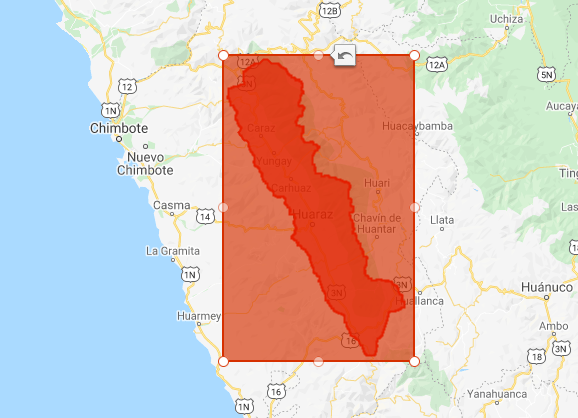

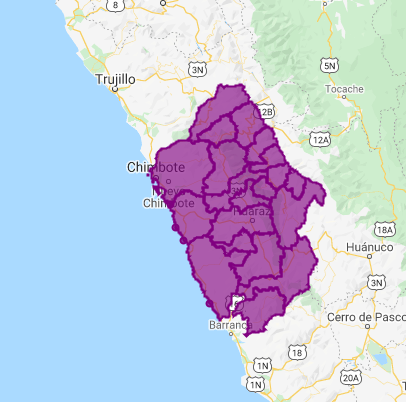

#### I have not found a way yet to easily use shapefiles in GEE python so for now lets stick to this
1. Option is to used just a rectangle, here named AOI
2. Option is to use a shapefile of Ancash which might be handy anyways

In [3]:
#1. Option: Ancash boundaries from FAOs GAUL dataset
gaul = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
ancash = gaul.filter(ee.Filter.eq('ADM1_NAME', 'Ancash'))

#2. Option: Rio Santa rectangle
RSR =  ee.Geometry.Polygon([[[-78.0201463433992,-10.263676352305339],
                             [-76.9709520074617,-10.263676352305339],
                             [-76.9709520074617,-8.605566365342705],
                             [-78.0201463433992,-8.605566365342705],
                             [-78.0201463433992,-10.263676352305339]]])
#Choose here:

AOI = RSR

In [4]:
#first we need a range of dates we are interested in, 
start = '1/1/2000' #first date of dataset
end = '1/1/2022' #just set somewhere into future to ensure you get all the data available

dates = pd.date_range(start=start,end=end,freq='YS')

#GEE has the potential to download endless amounts of data and to avoid that happening it has some limits in accessing 
#data, which can be a bit annoying. My workaround here is to download the data year by year. Often, this is not really 
#necessary, I think in this example you could also download some years together, but doing it yearly is a bit simpler 
#for programming. If the domain gets really big though even smaller timesteps might be necessary or you have to figure
#another way to overcome it! 

ds_ = list()
for i in range(1,len(dates)-1,1):

    print ('downloading year ' + str(dates[i-1])[0:4])
    
    #Define what data we want!
    
    collection = ee.ImageCollection('ECMWF/ERA5/DAILY').filterBounds(AOI)\
                      .filter(ee.Filter.date(str(dates[i-1].date()),str(dates[i].date())));

    #Get one image to extract scale and epsg
    image = collection.first()    
    
    #process and sort raw data
    files = collection.sort('system:time_start', True).select('minimum_2m_air_temperature','maximum_2m_air_temperature',
                                                              'mean_2m_air_temperature','total_precipitation')
    
    #get the nominal resolution of the data out of 1 image
    myScale = image.projection().nominalScale()
    
    #download the data
    files = files.getRegion(AOI,myScale.getInfo()).getInfo()
    
    #seperate header from numeric data
    header = files[0]
    data = np.array(files[1:])

    #make time dimension compatible for pandas
    timecol = header.index('time')
    time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,timecol].astype(np.uint64))]

    #put all that in a df and drop the id col
    df = pd.DataFrame(data, columns = header)
    df = df.drop(columns='id')
    
    #add correct timestamps and convert to float 
    df['time'] = time
    df["minimum_2m_air_temperature"] = pd.to_numeric(df["minimum_2m_air_temperature"],downcast='float')
    df["maximum_2m_air_temperature"] = pd.to_numeric(df["maximum_2m_air_temperature"],downcast='float')
    df["mean_2m_air_temperature"] = pd.to_numeric(df["mean_2m_air_temperature"],downcast='float')
    df["total_precipitation"] = pd.to_numeric(df["total_precipitation"],downcast='float')

    df["latitude"] = pd.to_numeric(df["latitude"],downcast='float')
    df["longitude"] = pd.to_numeric(df["longitude"],downcast='float')

    #multiindex and convert to 3D xarray
    df.set_index(['latitude', 'longitude','time'], inplace=True)
    ds = df.to_xarray()
    #append ds to ds_
    ds_.append(ds)

#merge all years
ds_f = xr.concat(([ds_[i] for i in range(len(ds_))]), dim='time')

downloading year 2000
downloading year 2001
downloading year 2002
downloading year 2003
downloading year 2004
downloading year 2005
downloading year 2006
downloading year 2007
downloading year 2008
downloading year 2009
downloading year 2010
downloading year 2011
downloading year 2012
downloading year 2013
downloading year 2014
downloading year 2015
downloading year 2016
downloading year 2017
downloading year 2018
downloading year 2019
downloading year 2020


In [5]:
#saving as netcdf file, complevel can be adjusted 0 (= no compression) to 9 (= max compression)
comp = dict(zlib=True, complevel=9)
encoding = {var: comp for var in ds.data_vars}
ds_f.to_netcdf('ERA5_data.nc', encoding=encoding)

In [8]:
#quick check if everything looks good!
final_ds = xr.open_dataset(r'ERA5_data.nc')
final_ds